In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd   

import torch
import pandas as pd

from scipy.interpolate import LinearNDInterpolator
device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:2
Device 2:  cuda:3


In [2]:
folder_main = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code/'
filename = 'AFSD_Exp_300.pt'
data_filename = 'Exponential_300_2mms.mat'

R0 = 5 #mm 5.34
Rs = 19 #mm
mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi
Omega = 300 #rpm
V = 2 #mm/s
F = 0.67 #mm
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig = 52 #mm^2/N
# A = np.exp(27.78)
log_A = 27.78
n = 3.49
k = 0.167 #Thermal Conductivity #W/(mmK)
c_p = 0.897 #J/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 0.0176 #W/(mmK)
c_p_t = 0.46 #J/gk
rho_t = 2700 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #W/mm^2K
C_bot = 0.15*1e-6 #W/mm^2K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-20.0,-20.0,-1.0])
ub_xyz_uvw = np.array([20.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-1.0])
ub_xyz = np.array([50.0,20.0,0.0])



In [3]:
from Seq_Model_Parallel import coupled_PINN

layers1 = np.array([3,50,50,50,4]) #9 hidden layers
layers2 = np.array([3,50,50,50,1]) #9 hidden layers
# layers = np.array([3,50,50,50,5])
# layers = np.array([3,64,64,64,1])
model_PINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)

model_PINN.load_state_dict(torch.load(folder_main + filename))

#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/' + data_filename)

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']

u_fvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_fvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_fvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2


Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
sigma_e_fvm = fvm_data['effectivestress']
eps_e_fvm = fvm_data['effstrrate']
mu_vis_fvm = fvm_data['mu']

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -20.0
x_max = 20.0

resol = 250

# x = np.linspace(x_min,x_max,250)
x = np.linspace(x_min,x_max,resol+1)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(y_min,y_max,resol+1)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
# y = 20.0
z = np.linspace(z_min,z_max,13)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2
# z = -0.1

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()


Res_v_PINN = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))

In [13]:
np.savetxt("xyz_PINN_28Aug24.csv",xyz,delimiter = ',')
np.savetxt("uvwp_PINN_28Aug24.csv",uvwp,delimiter = ',')

In [6]:
X,Y,Z = np.meshgrid(x,y,z)

X = X.reshape(resol,resol)
Y = Y.reshape(resol,resol)

# start_points = np.array([[-5.0,0.0],[-4.0,0.0],[0.1,0.0],[4.0,0.0],[5.0,0.0]]).reshape(5,2)

# start_points = np.array([[5.0,0.0]]).reshape(1,2)

U = uvwp[:,0].reshape(resol,resol)
V = uvwp[:,1].reshape(resol,resol)
W = uvwp[:,2].reshape(resol,resol)


ValueError: cannot reshape array of size 750000 into shape (250,250)

(-20.0, 20.0)

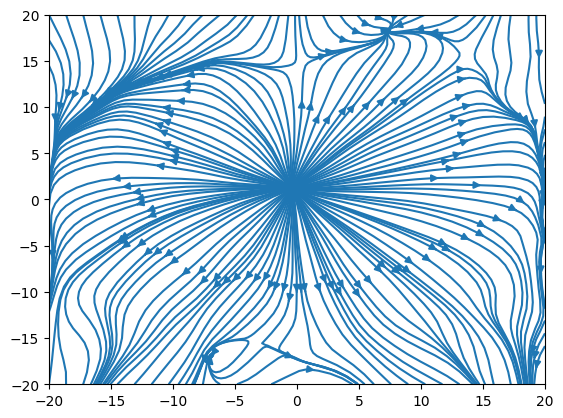

In [69]:
fig,ax  = plt.subplots()
# ax=plt.gca() 
ax.streamplot(X, Y, U, V,broken_streamlines=False)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
# axs[0].set_title('Varying Density')